# Introduction to Physical Activity Recognition 

This project aims to find statistical algorithms to detect and recognize physical activities of human using smartphones. The learning algorithms are based on classification models, using diverse unique extracted features. The current notebook includes following steps:
1. Reading the data that includes 12 different activities and different signals per activity and per participant. 
2. Feature extraction that considers both standardized and unstandardized features based on histogram, statistical analyses, and literatures.
3. Data cleaning to remove features that have near zero variation, high correlations, and multicollinearity.
4. Model fitting: LDA, Multinomial-LDA, KNN, Stepwise Regression, other cross validations. & Model Comparison to choose the best model that predicts the variable most accurately. 
5. Conclusion gives the overview of our work and reason why we chose the final model.
* Refer to the bottom of the page to see the contribution of the members.



# Data Preparation
### Installing tidyverse package and reading datasets from files

In [ ]:
#run tidyverse: the basis package for the current competition
library(tidyverse) 
list.files(path = "../input")
.... = NA

In [ ]:
# Make sure the data is available
if (length(list.files("../input", pattern = "recognition")) > 0) {
    
    # Copy all files to the current directory
    system("cp -r ../input/bda2022signals/* ./")
    
} else {
    
    # Download data for this competition
    data_url = "https://phonesensordata.netlify.app/Archive.zip"
    download.file(data_url, "Archive.zip")

    # Unzip all files in the current directory
    unzip("Archive.zip")
}

# list files in the current working directory
list.files()

# show the content of the labels file 
file.show("activity_labels.txt")

In [ ]:
# Train and Test folder are located in the RawData folder
list.files("./RawData")

# The Train folder contains 85 files:
length(list.files("./RawData/Train"))

# A sample of the file names in the Train folder; notice the filename pattern
set.seed(1)
sample(list.files("./RawData/Train"),6)


# 1. Reading the data

## 1.1 Import Activity labels

First import the activity labels:

In [ ]:
# store the signals for each user for each experiment 
# stores the activity labels for segments of signals

act_labels = read_delim("activity_labels.txt"," ",col_names=FALSE,trim_ws=TRUE) 
act_labels = act_labels %>% select(X1,X2)
act_labels 

In [ ]:
# stores the trial number, user ID, activity together with the sample number
labels = read_delim("./RawData/Train/labels_train.txt", " ", col_names = F)
colnames(labels) <- c('trial', 'userid', 'activity', 'start', 'end')

labels = labels %>% mutate(activity = act_labels$X2[activity])

#labels of the dataset
print(labels)

## 1.2 Import the signals

First look at participant with `userid` = 1, `trial` = 1 and see how we can import the signals, and then label each sample in the signal with the activity labels stored in the `labels` data frame.

In [ ]:
# identify the file name and extract the 'username' (participant ID) and 'expname' (experimental trial)
filename = "RawData/Train/acc_exp01_user01.txt"
username = gsub(".+user(\\d+).+", "\\1", filename) %>% as.integer()
expname  = gsub(".+exp(\\d+).+", "\\1", filename) %>% as.integer()

# import the data from the file
user01 = read_delim(filename, " ", col_names = F)
head(user01) #check nothing went wrong

Each column is a signal. Subsequent rows are subsequent measurement samples, and so we treat rownumber as a time indicator (to keep the distinction clear we'll talk about sample number).

Checking signal wave forms:

In [ ]:
options(repr.plot.width=12)

plot.ts(user01, xlab="Sample number")

Note: Different segments from horizontal axis correspond to different activities


## 1.3 Merging Signals and Labels
Merging data frame to have an acitivty label for each `trial`, `userid` and each time `sampleid` that has matching rows for each row in the signals data frame. 

In [ ]:
# Add the sequence start:end to each row in a list.
# The result is a nested table:
sample_labels_nested = 
    labels %>% 
    rowwise() %>% # do next operation(s) rowwise
    mutate(sampleid = list(start:end)) %>%
    ungroup()

# Check the resulting table:
print(sample_labels_nested, n=6) 

Note that dplyr prints only a summary of the 'sampleid' column, in a rather abstract way (e.g., `<int [983]>` under `sampleid` means: `sampleid` contains 983 integers for row 1).


Next we unnest the nested tibble `sample_labels_nested` to obtain a table that for each `sampleid` value stores the right `activity` label. Before unnesting, to solve issue of each roow corresponding to a signal segment of an activity, we'll add the row numbers as `segment` ID:


In [ ]:
# Unnest the nested tabel.
sample_labels = 
    sample_labels_nested %>% 

    # Rows are segments, we need to keep track of different segements
    mutate(segment = row_number() ) %>% 

    # Expand the data frame to one sample per row
    unnest(cols = c(sampleid)) %>% 

    # Remove columns we don't need anymore
    select(-start, -end) 


# Check the result (first few rows are not interesting; rows 977-990 are)
print(sample_labels[977:990, ])

Now that we have each sample labeled with an activity, we can add the corresponding signals values that are stored in `user01`:

In [ ]:
user_df = 
    # Store signals user01 in a data frame, with 'userid' and 'trial'
    data.frame(userid = username, trial = expname, user01) %>%

    # Add 'sampleid' for matching the sampleid's in 'sample_labels'. 
    # The first sample in user01 signals always has sampleid=0; the last
    # has sampleid is therefore nrow(user01)-1.
    mutate(sampleid = 0:(nrow(user01)-1) ) %>%

    # Add the labels stored in sample_labels
    left_join(sample_labels) 

# Check the result (first few rows are not interesting; the following are)
print(user_df[1227:1239, ])

Visualize the result by using `ggplot()` which allows to give different signal segments different colors to label the activity in that segment:

In [ ]:
options(repr.plot.width=15) # change plot width for nicer output

user_df %>% 
  ggplot(aes(x = sampleid, y = X1, col = factor(activity), group=segment)) + 
      geom_line()  

*Note: In the plot you'll notice the weird gray lines crossing through the plot. The gray trace corresponds to non-labeled segments (labeled `NA` in the legend of the plot). The segments that are labeled with an activity are interspersed with short unlabeled segments, which are drawn in gray, which causes the gray trace to connect different unlabeled segments.*

Notice that some samples have been labeled `NA`, meaning _any activity that is not on the list_. Whole sections of signal consist of this unlisted activity.


# 2. Feature Extraction

Following plot shows segments with typical walking cycles, and that time samples themselves are not useful features:

1. that we don't know how long the typical pattern is (i.e., how many samples it spans), and 
2. that the pattern may be shifted relative to the start of our time window so that it appears _shifted_ 


In [ ]:
user_df %>% 

  # change 7986 to 8586 to see shifted walk cycle
  dplyr::filter(activity == "WALKING", segment == 13, 
    7596 < sampleid & sampleid < 7986) %>% 

  ggplot(aes(x = sampleid %% 54, y = X1, group = sampleid %/% 54, 
             col = factor(sampleid %/% 54))) + geom_line() 

Thus, what we have to do is compute features that are (more or less) invariant to time shifts by ignoring the time order of the values and look at them as a collection of numbers. The best way to look at unordered collections of numbers is to look at statistical summaries.

Below is the histograms of the signal samples per activity:

In [ ]:
user_df %>%
    ggplot(aes(X1)) + 
      geom_histogram(bins=40, fill=1, alpha=0.5) + 
      geom_histogram(aes(X2), bins=40, fill = 2, alpha=0.5) + 
      geom_histogram(aes(X3), bins=40, fill = 4, alpha=0.5) +
      facet_wrap(~activity, scales = "free_y")

### Epochs

Now there's one other thing concerning these signals: The signals have different activities at different times, and in general, we don't know when an activity is going to start or end. 

In the Test data set you will be asked to predict the activities in subsequent time windows, called _epochs_, of 128 samples (=128 / 50Hz = 2.56 sec). So you will also have to train a prediction algorithm on the signals that are segmented into _epochs_ of 128 samples.

We use this trick to group the rows in `user` into epochs, and then compute summary statistics per epoch. The result is a data frame with as many rows as there are epochs, and on each row the summary statistics computed. 

In [ ]:
user_df %>%
  # add an epoch ID variable (on epoch = 2.56 sec)
  mutate(epoch = sampleid %/% 128) %>% 
  # group by 'epoch'
  group_by(epoch) %>%
  # compute mean features and standard deviation features
  summarise(mean_X1 = mean(X1), mean_X2 = mean(X2), mean_X3 = mean(X3)) %>%
  # inspect the first 6 epochs
  head()

What we did here was the following

1. We divided up the samples into 'epochs' (and computed an 'epoch' id),
2. we then grouped the resulting data frame by 'epoch' id,
3. and then we computed the mean of the signal samples in each epoch, for each of the 3 signals

## 2.1 Functions for Feature Extraction

### FEATURE DESCRIPTIONS ###

#### Time domain features:

Time domain features are included in general to detect the time aspect of the signals, showing the signal changes over time. These below features show more of in-depth interpretation of signals changes over time. For instance, correlations and autocorrelations would quantify the changes.

* **_Level_**: It simply indicate the mean across the samples of a signal. It can inform the changes over time by detecting the dynamics in mean signals.
* **_Power_**: It represents the average squared amplitude of the signal. Power reflects the loudness of the signal, indicating the deviation from an absolute zero of X. The loudness may differ in different activities, as the strength of each activty differs. 
* **_Energy_**: It is the total power of the n samples. It may aid on distingushing between activities as the power of the signals all differ per activity. 
* **_Entropy_**: It interprets the average surprise of an observed value from histogram. The differences show by how low or high the probabililties are: the higher the probability, the less 'surprised' you are. 
* **_Autocorrelation_**: It is interesting to extract because it aids differentiating activities; for instance, slowly changing signals have high autocorellations, while fast changing signals have low or even negative autocorrelations.
* **_Correlation_**: They also show differences by showing the changes from one point to another; if they have high correlation, it indicates the slow changes, while high correlation shows fast changes.


#### Sub-Time domain Features - Statistical features:

Histograms give a detailed picture of the distribution of the numbers that make up the signal. Based on this, we will be extracting a less detailed characterization of the distribution, such as their location of the distribution (i.e., the _mean_), and the width of the distribtuion (_standard deviation_). These features show differences in general signals or wave forms, which could help differentiating between activities. These simple statistical summary measures often yield good predictive features. We used the following histogram features:
* _Mean_, _Standard Deivations_, _Quantiles_, _Skewness_, _Median_, _Mode_, _Maximum and Minimum_, _Kurtosis_
* _Standard Error_, _Root Mean Squared_

#### Frequency domain features: 

Frequency domain features show how signals are presented over each frequency band. This could be detected by signal spectrum that compares between different activities in each frequency band. 

* **_Mean frequency_**: We used general mean frequency to find which activity has higher mean frequency and what not. 
* **_Spectral peak, spectral mean frequency, spectral standard deviation, spectral entropy_**:
    - The spectrum of a signal shows which frequencies a signal is composed of. It shows the number of fluctuations, including signals like a walking patterns ... etc. Peaks show the strength in which peaks are presented. Notice that height of each frequency is the square of a linear regression coefficient, meaning we can use to predict the signals from a wave. These spectral features can be used as a probability density function as well (ex, mean frequency). 
 
#### Other features:
 
* **_Convolutions_**: For pattern recognition we used convolution. Convolution is a filter that passes over for example an image and extracting features that show a commonolatity in the image (signals) such that if the image has certain features, it belongs to a particular class. Thus, aiding in detecting activity. 
* **_Zero crossings_**: It measures how many times the waveform crosses the zero axis. With zero crossing we are able to see whether the sign of a signal changed. Since our goal is to distinguish different physical activities this can be useful. 
* **_Coefficient variance_**: It is the spread of the values in the epoch. The differences in values can be an indication of which signals in each epoch are different per activities. 
* **_Width/heigth ratio_**: It is the ratio of width and height of the wave. This is an unstandardized method, which we aim to learn the differences in proportion of width and heigh of each signals per activity. 
* **_Signal Magnitude Area (SMA)_**: statistical measure of the magnitude of a varying quantity that shows indication of different area in each signal.

#### Features we did not use:

* **_Amount of peaks_**: Here we counted the amount of peaks that could be found in the epoch, as in different activities, we can see different amount of peaks. We thought it could be a good predictor for detecting which activity belongs to how many amount of peaks.
* **_Difference between highest and lowest peak_**: As seen in one of the earlier diagrams you can see that sitting has a small difference between signals while wallking has a lot higher peaks then their valleys so this could help define the different classes.
* **_Average distance between the valleys_**: The amount of time that passed between signals also seemed to differ accros the different classes. So here we look at the distance between valleys and average it.

#### References
* Reyes-Ortiz, J. L., Oneto, L., Samà, A., Parra, X., & Anguita, D. (2016). Transition-aware human activity recognition using smartphones. Neurocomputing, 171, 754-767. DOI:10.1016/j.neucom.2015.07.085
* Grasman, R. (2018). Feature extraction from Signals. DropBox. https://paper.dropbox.com/doc/Feature-extraction-from-Signals-qCp5uvj47gmyuw5nmB8lL
* https://rug.mnhn.fr/seewave/HTML/MAN/zcr.html https://ieeexplore.ieee.org/document/540290 https://www.sciencedirect.com/topics/engineering/zero-crossing-rate
* https://rpubs.com/eR_ic/conv_pools

### FUNCTION CREATION ###

Features function are created to aid the calculation simplification. Below are the functions listed in the order of time domain, statistical, frequency, and other features.
> The built-in functions are excluded from the below block, but only in the 'Step 3: Putting it all together' step.

In [ ]:
# Helper functions
most_common_value = function(x) {
    counts = table(x, useNA='no')
    most_frequent = which.max(counts)
    return(names(most_frequent))
}

#### TIME DOMAIN FEATURES ####

# Level function
lev_fun <- function(x){
    lev = (1/length(x)) * sum(x)
    return(lev)
}

# Energy function
energy_fun = function(x) {
    ener = sum((x - mean(x))^2) 
    return(ener)
}

# Entropy function
ent_fun  <- function(x, nbreaks = nclass.Sturges(x)) {
    r = range(x)
    x_binned = findInterval(x, seq(r[1], r[2], len= nbreaks))
    h = tabulate(x_binned, nbins = nbreaks) # fast histogram
    p = h/sum(h)
    -sum(p[p>0] * log(p[p>0]))
}

# Autocorrelation function
lagged_cor = function(x, y=x, lag=0) {
    # compute correlation between x and a time shifted y
    r_lagged = cor(x, dplyr::lag(y, lag), use='pairwise')
    r_lagged = ifelse(is.na(r_lagged),0,r_lagged)
    return(r_lagged)
}

#### STATISTICAL FEATURES ####

# Interquartile Range function
iqr_fun <- function(x) {
    iqr = quantile(x, .75) - quantile(x, .25)
    return(iqr)
}

# Mode function
mode_fun <- function(x) {
    mode = as.integer(which.max(table(x)))
    return(mode)   
}

# Standard Error function
se_fun <- function(x) {
    se = sd(x) / sqrt(length(x))
    return(se)
}

# Root Mean Square function
rms_fun <- function(x){ #only on vectors
    rms = sqrt((1/length(x)*(sum(x^2))))
    return (rms)
}

#### FREQUENCY DOMAIN FEATURES ####

# Mean Frequency function
mean_freq <- function(x) {
    out_1 = numeric()
    for (i in 1:length(x)){
        out_1[i] = i * x[i] }
        return(sum(out_1)/sum(x))
}

#Spectral Peak function
spec_peak = function(x) {
    spec = spectrum(x, log = 'n', plot = FALSE)
    peak = spec$freq[which.max(spec$spec)]
    return(peak)
}

# Spectral Mean Frequency function
spec_mean_freq <- function(x) {
    spec = spectrum(x, log = 'n', plot = FALSE)
    df = spec$freq[2] - spec$freq[1]
    sbar = sum(spec$freq * spec$spec * df)
    return(sbar)
}

# Sepctral Standard Deviation function
spec_sd <- function(x) {
    spec = spectrum(x, log = 'n', plot = FALSE)
    df = spec$freq[2] - spec$freq[1]
    svar = sum((spec$freq - mean(x))^2 * spec$spec * df)
    return(svar)
}

# Spectral Entropy function
spec_ent <- function(x) {
  spec = spectrum(x, log='n', plot = FALSE)$spec
  ent_fun(spec)
}

#### OTHER FEATURES ####

# Pattern detection by convolutional neural networks function
conv_fun <- function(x, m) {
    w = 1/(2*m+1)
    conv = max(stats::filter(x, w, method = 'convolution'))
    return(conv)
}

# Signal Magnitude (SMA) function
sma_fun <- function(x1,x2,x3){
    sma <- (1/3) * sum(abs(c(x1,x2,x3)))
    return(sma) }

What we did here is following:
1. Build functions that will necessarily simplify the feature extraction process (or simplify the codes)
2. Without using many packages, build unique functions based on mathematical formulas of the function from literatures and slides (see above for citation lists)
3. Divide each section based on statistical, histogram based, time domain, frequency domain, and other (not-defined) features

Now we'll be extracting/ computing features per epoch.

# 3. Putting it all together

All the manual and built-in functions are applied to the below feature extraction process. 
All the functions are divided into four sections, in the order of time domain, statistical, frequency, and other features.


In [ ]:
extractTimeDomainFeatures <- function(filename, sample_labels) {
    
    # extract user and experimental run ID's from file name
    username = gsub(".+user(\\d+).+", "\\1", filename) %>% as.numeric()
    expname  = gsub( ".+exp(\\d+).+", "\\1", filename) %>% as.numeric()
    
    # import the sensor signals from the file
    user01 <- read_delim(filename, " ", col_names = F, progress = TRUE, 
                 col_types = "ddd")
    
    # merge signals with labels 
    user_df <- 
        data.frame(userid = username, trial = expname, user01) %>%
        mutate(sampleid = 0:(nrow(user01)-1) ) %>%
        left_join(sample_labels, by = c('userid','trial','sampleid')) 

    
    # split in epochs of 128 samples and compute features per epoch
    usertimedom <-  user_df %>%
    
          # add an epoch ID variable (on epoch = 2.56 sec)
          mutate(epoch = sampleid %/% 128) %>% 

          # extract statistical features from each epoch
          group_by(epoch) %>%
          summarise(
              
            # keep track of user and experiment information
            user_id = username, 
            exp_id = expname,   
              
            # start sample
            sampleid = sampleid[1],
            
            # keep track of signal lengths
            n_samples = n(),
            
            # epoch's activity labels
            activity = most_common_value(c("-", activity)),
              
            # Computing time domain features: 
              ## Level:
              level1 = lev_fun(X1),
              level2 = lev_fun(X2),
              level3 = lev_fun(X3),

               ## Power:
              power1 = mean(X1^2),
              power2 = mean(X2^2),
              power3 = mean(X3^2),
              
              ## Energy:
              energy1 = energy_fun(X1),
              energy2 = energy_fun(X2),
              energy3 = energy_fun(X3),
              
              ## entropy:
              ent_1 = ent_fun(X1),
              ent_2 = ent_fun(X2),
              ent_3 = ent_fun(X3),
              
              ## autocorrelation:
                  ### computing for lag = 1
                  AR1_1 = lagged_cor(X1, lag = 1),            
                  AR2_1 = lagged_cor(X2, lag = 1), 
                  AR3_1 = lagged_cor(X3, lag = 1),
                  AR12_1 = lagged_cor(X1, X2, lag = 1),
                  AR13_1 = lagged_cor(X1, X3, lag = 1),
                  AR23_1 = lagged_cor(X2, X3, lag = 1),

                  ### computing for lag = 2
                  AR1_2 = lagged_cor(X1, lag = 2),            
                  AR2_2 = lagged_cor(X2, lag = 2), 
                  AR3_2 = lagged_cor(X3, lag = 2),
                  AR12_2 = lagged_cor(X1, X2, lag = 2),
                  AR13_2 = lagged_cor(X1, X3, lag = 2),
                  AR23_2 = lagged_cor(X2, X3, lag = 2),
              
              ## Pearson correlation coefficient:
              cor12 = cor(X1, X2, method = "pearson", use = "complete.obs"),
              cor13 = cor(X1, X3, method = "pearson", use = "complete.obs"),
              cor23 = cor(X2, X3, method = "pearson", use = "complete.obs"),

            # Computing statistical features:
              ## mean:
              m1 = mean(X1), 
              m2 = mean(X2),
              m3 = mean(X3),

              ## standard deviations:
              sd1 = sd(X1), 
              sd2 = sd(X2),
              sd3 = sd(X3),

              ## quantiles:
              q1_25 = quantile(X1, .25),
              q2_25 = quantile(X2, .25),
              q3_25 = quantile(X3, .25),
              q1_75 = quantile(X1, .75),
              q2_75 = quantile(X2, .75),
              q3_75 = quantile(X3, .75),
              
              ## IQR: exclude them because they create a high correlations with quantiles (already delivers the same information)
              #iqr1 = iqr_fun(X1),
              #iqr2 = iqr_fun(X2),
              #iqr3 = iqr_fun(X3),

              ## skewness:
              skew1 = e1071::skewness(X1),
              skew2 = e1071::skewness(X2),
              skew3 = e1071::skewness(X3),

              ## Median absolute deviation:
              mad1 = mad(X1),
              mad2 = mad(X2),
              mad3 = mad(X3),
              
              ## mode:
              mode1 = mode_fun(X1),
              mode2 = mode_fun(X2),
              mode3 = mode_fun(X3),

              ## Maximum and Minimum:
              max1 = max(X1),
              max2 = max(X2),
              max3 = max(X3),
              min1 = min(X1),
              min2 = min(X2),
              min3 = min(X3),
              
              ## kurtosis
              kur1 = e1071::kurtosis(X1),
              kur2 = e1071::kurtosis(X2),
              kur3 = e1071::kurtosis(X3),
              
              # Standard Error:
              se1 = se_fun(X1),
              se2 = se_fun(X2),
              se3 = se_fun(X3),
              
              # Root mean square: 
              rms1 = rms_fun(X1),
              rms2 = rms_fun(X2),
              rms3 = rms_fun(X3),
              
              ## Coefficient of variance
              coefvar1 = sd1/m1,
              coefvar2 = sd2/m2,
              coefvar3 = sd3/m3,
              
              ## mean frequency:
              mfreq1 = mean_freq(X1),
              mfreq2 = mean_freq(X2),
              mfreq3 = mean_freq(X3),
              
              ## spectral peak:
              peak1 = spec_peak(X1),
              peak2 = spec_peak(X2),
              peak3 = spec_peak(X3),

              ## spectral mean frequency:
              s_meanfreq1 = spec_mean_freq(X1),
              s_meanfreq2 = spec_mean_freq(X2),
              s_meanfreq3 = spec_mean_freq(X3),

              ## spectral standard deviation:
              s_sd1 = spec_sd(X1),
              s_sd2 = spec_sd(X2),
              s_sd3 = spec_sd(X3),
              
              ## spectral entropy:
              s_ent1 = spec_ent(X1),
              s_ent2 = spec_ent(X2),
              s_ent3 = spec_ent(X3),

            # Others
              ## pattern detection:
              conv1 = conv_fun(X1, length(unique(epoch))), #defining length of unique(epoch) as m (limited number of samples)
              conv2 = conv_fun(X2, length(unique(epoch))),
              conv3 = conv_fun(X3, length(unique(epoch))),

              ## Zero-Crossings:
              crossing1 = 0.5 * mean(abs(sign(X1 * (sampleid + 1)) - sign(X1 * sampleid))), #here t is defined as sampleid
              crossing2 = 0.5 * mean(abs(sign(X2 * (sampleid + 1)) - sign(X2 * sampleid))), 
              crossing3 = 0.5 * mean(abs(sign(X3 * (sampleid + 1)) - sign(X3 * sampleid))), 

              ## SMA:
              SMA = sma_fun(X1, X2, X3),

              ## Width height of histogram ratio:
              whratio1 = X1[which.max(X1)]/length(sampleid),
              whratio2 = X2[which.max(X2)]/length(sampleid),
              whratio3 = X3[which.max(X3)]/length(sampleid),

              # Difference between highest peak and lowest valley:
              diff_pv1 = max(X1) - min(X1),
              diff_pv2 = max(X2) - min(X2),
              diff_pv3 = max(X3) - min(X3)
          ) 
    
    usertimedom
}


In [ ]:
# run this to see if all functions are working well/ see raw data outputs
filename = "./RawData/Train/acc_exp01_user01.txt"
df = extractTimeDomainFeatures(filename, sample_labels) 
head(df) #to visaulize the dataframe

Now we'll combine both acc and gyro files into one big file:

In [ ]:
#accelorometer file 
acc_filenames <- dir("./RawData/Train/", "^acc", full.names = TRUE)
#gyroscope file
gyro_filenames <- dir("./RawData/Train/", "^gyro", full.names = TRUE) 

# map_dfr runs `extractTimeDomainFeatures` on all elements in 
# filenames and binds results row wise
acc_myData = map_dfr(acc_filenames, extractTimeDomainFeatures, sample_labels) #files with acc
gyro_myData = map_dfr(gyro_filenames, extractTimeDomainFeatures, sample_labels) #files with gyro

# Check the result
#head(myData1)
#head(myData2)

#merge them into one big file
train_myData <- acc_myData %>%
    left_join(gyro_myData, 
              by = c('epoch', 'user_id', 'exp_id', 'sampleid', 'n_samples', 'activity'),
              
              #changing the name of features with _acc or _gyro depends on file
              suffix = c("_acc", "_gyro")) %>% # to distinguish the variables by both sensors
    select(-activity, activity) #activity as last label (from Group 8)
head(train_myData)

## 3.1 Data Pre-Processing

Using obervation and caret package to remove redundant variables
* Variables that only gives output of 0 or NAs
* Variables with near zero variation
    - Have all same values or all NAs
    - Compare most frequent to second most frequent value
    - Compare number of unique values to number of observations
* Variables that are highly correlated
    - High correlation between variables provide similar or same information
    - May be an indicator of instability of coefficient estimates

In [ ]:
# Remove all the NAs from the the dataset 
# credit to Group 8

myData_final <- train_myData %>%
    drop_na() %>%
    dplyr::select(-c(epoch:n_samples))

In [ ]:
# check for near zero variation
nonearva <- caret::nearZeroVar(myData_final %>%
    dplyr::select(-activity))

# check for high correlations
var <- cor(myData_final %>%
    dplyr::select(-activity)) %>% 
    caret::findCorrelation(0.9)

# cleaning the data
myData_clean <- myData_final %>% 
    dplyr::select(-all_of(c(nonearva, var)))

Next step, we will be using car package to remove multicollinear variables:
* Aims to remove the variables in a regression that are correlated with each other
* Variance inflation factor (VIF) is the ratio of the variance of variables when fitting the full model divided by the variance of variables if fit on its own (ISLR Chapter 3-4).

In [ ]:
# Credits to Group 8

VIF <- function(data) {
    vif_over <- c() # creating list to store affected column names
    for (i in 1:(length(data)-1)){
      lmp <- paste(colnames(data[, i, drop = F]), 
                   "~", 
                   paste(colnames(data[,-c(i,(length(data)-1))]), collapse = "+"))
      # above line creates a formula string for each predictor regressed on all others
      fit <- lm(data = data, formula = lmp) # fitting the model using the formula string
      VIF <- 1/(1 - summary(fit)$r.squared) # calulcating the VIF
      #print(paste(colnames(data[, i, drop = F]), VIF, sep = ": "))

      if (VIF > 10){
          vif_over <- append(vif_over, colnames(data[,i])) # storing features with VIFs>10
      }
    }
    return(vif_over)
}


# Removing the observations that show high multicollinearity (VIF > 10)
myData_cleanM <- myData_clean %>% 
    dplyr::select(-all_of(VIF(myData_clean)))

head(myData_cleanM) #visualize the final clean data frame

# 4. Model fitting
## 4.1 Linear Discriminant Analysis
Linear discriminant analysis (LDA) is one of the classification methods that is bascially a linear regression analysis with a dichotomous outcome (0 or 1). The characteristics of LDA is that it can 1) formulate for any distribution, 2) models distribution of the predictor variables within each class k, and uses Bayes theorem to compute the posterior probability that an observation belongs to class k, 3) assumes a normal distribution for X. If the normal distribution is correct, LDA's decision boundaries are the Bayes decision boundaries that yield the lowest number of misclassifications among all classification models. Thus, we are using LDA to fit our predictors. (ISLR Chapter 4)

For validating the model, we used k = 10 because typically, k = 5 or 10 are ideal values to yield test error rate estimates that suffer neither from excessively high bias nor from very high variance, so we chose k = 10 as our cross validation.

FINE TUNING AND STEPWISE REGRESSION FOR LDA
* During the process of finding ways to tune LDA, we found out that according to the documentation LDA has no tuning parameters.
    - http://topepo.github.io/caret/available-models.html
* We tried using stepLDA to fit stepwise regression for LDA, but due to high computational power it did not successfully run, so we decided to leave it out.


In [ ]:
## Fitting classifier models
# 10-fold
trcntr = caret::trainControl('cv', number = 10) 

#fitting Linear Discriminant Analysis
fit_lda = caret::train(activity ~ ., data = myData_cleanM, method="lda", trControl = trcntr, na.action = na.pass)
fit_lda

## 4.2 K-Nearest Neighbors

K-nearest neighbors (KNN) is a non-parametric approach, meaning it does not assume anything of the decision boundary. One of the advantages of non-parametric model is that it can display better output when the decision boundary is non-linear. Since we have a lot of observations, we would expect less bias outcome. The flexibility of KNN would thus be appropriate for our model. 

TUNING
* According to the documentation knn has one tuning parameter: k
* For the ideal amount of k sould be the squarroot of the amount of samples we have. Since we have 20597 samples the squareroot will be 143.5 so we will look for a k around that number.
    - According to https://towardsdatascience.com/how-to-find-the-optimal-value-of-k-in-knn-35d936e554eb#:~:text=The%20optimal%20K%20value%20usually,be%20aware%20of%20the%20outliers.

In [ ]:
set.seed(1) #to avoid randomness
sqrt(max(user_df$sampleid)) #to see the optimal k value for tuning process

#fitting k-Nearest Neighbors
#size matters for knn so standardizing features are important
#with fine-tunning
hyperparams <- expand.grid(k = seq(140,150,1))
fit_knn <- caret::train(activity ~ ., data = myData_cleanM, method="knn", trControl = trcntr, tuneGrid = hyperparams, preProcess = 'scale')
fit_knn # the output shows the final value of k

#without fine-tunning
fit_knn_wo <- caret::train(activity ~ ., data = myData_cleanM, method="knn", trControl = trcntr, preProcess = 'scale')
fit_knn_wo

#for visualization of ideal k, credit to Group 7
plot(fit_knn)
plot(fit_knn_wo)

## 4.3 Multinomial Logistic Regression
When there are more than two classes, multinomial logitistic regression can be an appropriate model (as an extension from normal logistic regression model). However, our group decided to not use the model because the fitted MLR model required a high computational power and yield a low accuracy compared to that of others. Considering these factors, we thought it is not necessary to display the codes. These are the outputs we got:

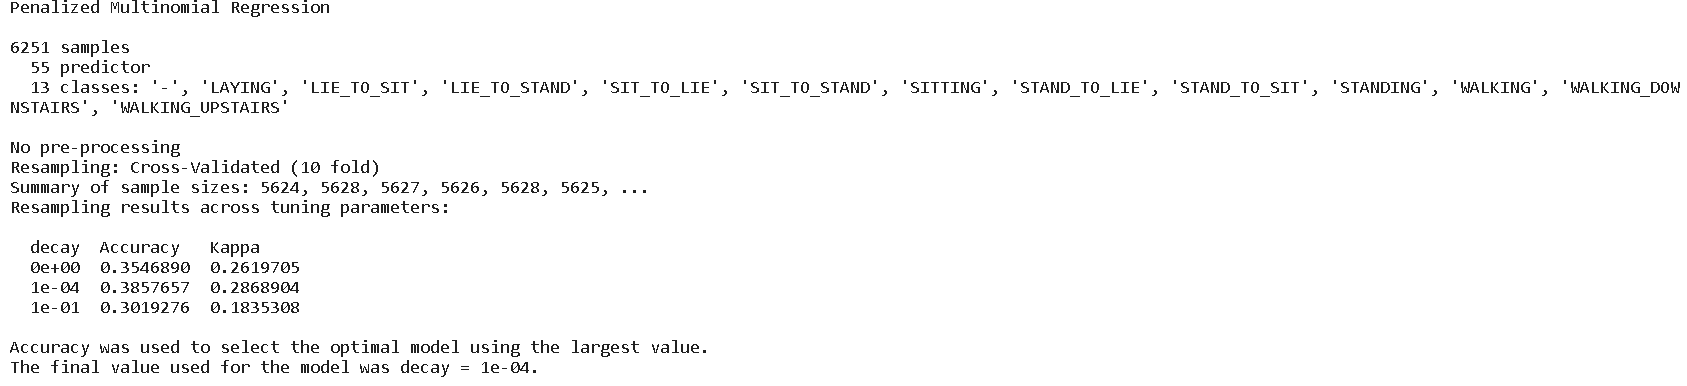

## 4.4 Cross-Validation

Cross-validation is a common resampling methods: it can be used ot estimate the test error to evaluate the performance, and select the appropriate level of flexibility. This is also known as *model assessment*. We used k-fold cross validation for our knn model because it does not take much computational power as compared to LOOCV. Also, we can determine how well a given statistical learning procedure can be expected to perform on independent data. (ISLR Chapter 5)

* LOOCV for LDA was not used due to high computational power.



In [ ]:
# CV for KNN
# 10-fold CV
# set the 'train control'

trControlKNN <- trainControl(method = "cv", number = 10)
fit_cv_knn <- caret::train(activity ~ ., method = "knn", 
                         tuneGrid = expand.grid(k= 1:10), 
                         trControl = trControlKNN, 
                         metric = "Accuracy", 
                         data = myData_cleanM,
                         preProcess = 'scale') #standardizing features
fit_cv_knn

## 4.5 Model Comparison

Below, we visualized accuracy of different models with two different graphs:
* Bar plot: simply visualizes the best accuracy among all the models we have fitted
* Scatterplot with confidence interval: visualizes the accuracy rate as well as the range of confidence interval

In [ ]:
#bar graph that visualizes the best accuracy among different models
# credit to Raoul
all_models <- list(lda = fit_lda, knn = fit_knn, knnwo = fit_knn_wo, cv_knn = fit_cv_knn) #update when more models are added
#extract the cross-validated accuracies from each model
Acc = sapply(all_models, function(md1) {max(md1$results$Accuracy)})
# make a barplot with only the best perfroming model in red
color = 1 + (Acc >= max(Acc))
b <- barplot(Acc, horiz = T, las=1, col = color) 
             
# Accuracy with confidence interval graph
# Credit to group 4
ggplot(resamples(all_models)) +
    labs(y = "Accuracy") + 
    theme_linedraw() +
    scale_y_reverse()

### Confusion Matrix for the final model

Confusion matrix is displayed below to compare the predictions to the true default statuses for the training observations. It shows the frequencies of each class being correctly or incorrectly classified to each other. More details can be found in conclusion section.

In [ ]:
# Confusion matrix CV- KNN
# Make train and test dataset
train_split_idx <- caret::createDataPartition(myData_cleanM$activity, p = 0.75, list = FALSE)
train <- myData_cleanM[train_split_idx, ]
test <- myData_cleanM[train_split_idx, ]

train[["activity"]] = factor(train[["activity"]])
test[["activity"]] = factor(test[["activity"]])

# Prediction
fit_cvknn_predict <- predict(fit_cv_knn, newdata = test)

# confusion matrix
cm_cvknn <- confusionMatrix(test$activity, fit_cvknn_predict)

cm_cvknn[2:4] #print out table, overall accuracy, and specificity & sensitivity for each class

# other ways to display the outputs
# table cm
# cm_cvknn_table <- cm_cvknn$table
# make table of statistics
# cm_cvknn_st <- data.frame(cm_cvknn$overall)


# Conclusion:

The aim of our project was to detect and recognize physical activities of human, recorded by smartphones. We added several features, including features we came up with ourselves based on literature research. Unfortunately, we were not able to use all the features we came up with. For instance, while reading different literatures, we found out that package quantmod provides some fruitful information about the signals. Thus we tried to extract the mathematical formulas out of the package, but due to the difficulty of recreating the package and time pressure, we ended up not using the features. We fitted several models to our data to predict the activities. All accuracies are visualized in the plot under the heading “model comparison”. As can be clearly seen there, the cross-validated knn model gave the best accuracy, as well as smallest range of confidence intervals. However, due to the curse of dimensionality, knn is more prone to overfitting. Although feature selection and dimensionality reduction techniques can be used to avoid this, the results should still be interpreted with caution. In the future, other features, such as the peak and valley feature could be added to investigate whether this improves accuracy. For instance, it seems to be hard to distinguish between 'Lie to sit' and 'Lie to stand' based on the confusion matrix: while 'Lie to stand' was correctly classified with 'Lie to stand' 19 times, 'Lie to sit' to 'Lie to stand' was incorrectly classified for 11 times. This indicates that those two categories are quite similar, which could possibly be improved with peaks and valleys features.

## Sub-Section: Peaks and Valleys:
When looking at the plot below (same as earlier) we see that different activities have different values for the signals. We also see in this plot that there is a clear difference between the vallues that are associated with walking downstair and laying for example. one difference we see is that the average of the signal for walking downstairs is higher then for laying. We also see that the amount of higher/lower values for walking down stairs seems to be higher then those for laying. So here we can definately see some reasons to think that peaks and valleys of a time period could help distinguis the different activities from eachother.

In [ ]:
options(repr.plot.width=15) # change plot width for nicer output

user_df %>% 
  ggplot(aes(x = sampleid, y = X1, col = factor(activity), group=segment)) + 
      geom_line()  

To do this we first used a package (quantmod) which has an algorithm that compairs a time x with its time x-1 and a time x+1. This algorithm then defines a peak when both X-1 and X+2 are smaller than X. It defines a valley the other way around. In the graph below we can see this package working on the data. 

documentation for the peaks and valleys functions can be found:
 - https://search.r-project.org/CRAN/refmans/quantmod/html/peak.html for peaks
 - https://www.rdocumentation.org/packages/geodiv/versions/1.0.1/topics/findvalleys for valleys

In [ ]:
#here we find which points are the peaks of a sequence in time
p <- quantmod::findPeaks(user_df$X1[1:128]) -1

#here we find the points which are the valleys of the sequence of time
v <- quantmod::findValleys(user_df$X1[1:128]) -1

#visualization
plot(user_df$X1[1:128],type = 'l')
points(p,user_df$X1[p], col = "red")
points(v,user_df$X1[v],col = "blue")

However, in this competition using this package was prohibited, so we had to think up another way. Making a function that compairs the three values is the easy part (this part is shown below). However it should work in the current give format which was way harder to work with. Thus, it was decided to not venture further into this rabit hole.
Below is to demonstrate the work we did:

In [ ]:
max <- 128
period <- user_df$X1[1:max]
peak = c()
if(period[1] < period[2]) peak[1] = 0 else peak[1] = 1
    
for(time in 2:(max-1)){
    if(period[time] > period[time -1] & period[time] > period [time+1]) peak[time] = 1 else peak[time] = 0
        }
if(period[max] > period[max-1]) peak[max] = 1 else peak[max] = 0

valley = c()
if(period[2] < period[1]) valley[1] = 0 else valley[1] = 1

for(time in 2:(max-1)){
    if (period[time] < period[time -1] & period[time] < period[time +1]) valley[time] = 1 else valley[time] = 0
}
if(period[max] < period[max-1]) valley[max] = 1 else valley[max] = 0

valley <- which(valley == 1)
peak <- which(peak == 1)

plot(user_df$X1[1:max], type = 'l') +
points(peak,user_df$X1[peak], col = "red") +
points(valley,user_df$X1[valley], col = "blue")

# 5. Submissions


The test data can be imported in the same way as the training data, you only have to change `Train` to `Test` in the directory path:

In [ ]:
#acc file 
acc_filenames_test <- dir("./RawData/Test/", "^acc", full.names = TRUE)
#gyro file
gyro_filenames_test <- dir("./RawData/Test/", "^gyro", full.names = TRUE) 

# map_dfr runs `extractTimeDomainFeatures` on all elements in 
# filenames and binds results row wise
myData1_test = map_dfr(acc_filenames_test, extractTimeDomainFeatures, sample_labels) #files with acc
myData2_test = map_dfr(gyro_filenames_test, extractTimeDomainFeatures, sample_labels) #files with gyro

#merge them into one big file
myData_test <- myData1_test %>%
    left_join(myData2_test, #joining the data; do I use full_join or inner_join..?
                       by = c('epoch', 'user_id', 'exp_id', 'activity', 'sampleid', 'n_samples'),
                   suffix = c("_acc", "_gyro")) 
head(myData_test)

In [ ]:
filenames_test = list.files("./RawData/Test/", "^acc", full.names = TRUE)
filenames_test

## Formatting the submission file

To help you turning your predictions into the right format, the following code can help. Here it is executed on the training set data frame, but the same can be applied to the test set data frame.

In [ ]:
#prediction
pre_test = predict(fit_cv_knn, new = myData_test)

predictions = myData_test %>%
    mutate(activity = pre_test)

dim(predictions)

In [ ]:
predictions %>%
    # prepend "user" and "exp" to user_id and exp_id
    mutate(
        user_id = paste(ifelse(user_id < 10, "user0", "user"), user_id, sep=""), 
        exp_id = paste(ifelse(exp_id < 10, "exp0", "exp"), exp_id, sep="")
    ) %>% 

    # unit columnes user_id, exp_id and sample_id into a string 
    # separated by "_" and store it in the new variable `Id`
    unite(Id, user_id, exp_id, sampleid) %>%

    # retain only the `Id` and  predictions
    select(Id, Predicted = activity) %>%

    # write to file
    write_csv("submission.csv")


# Check the result: print first 20 lines in the submission file
cat(readLines("submission.csv",20), sep="\n")
